<a href="https://colab.research.google.com/github/dieund/CS2225.CH1501/blob/master/nhandiencmnd/NhanDienCMND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

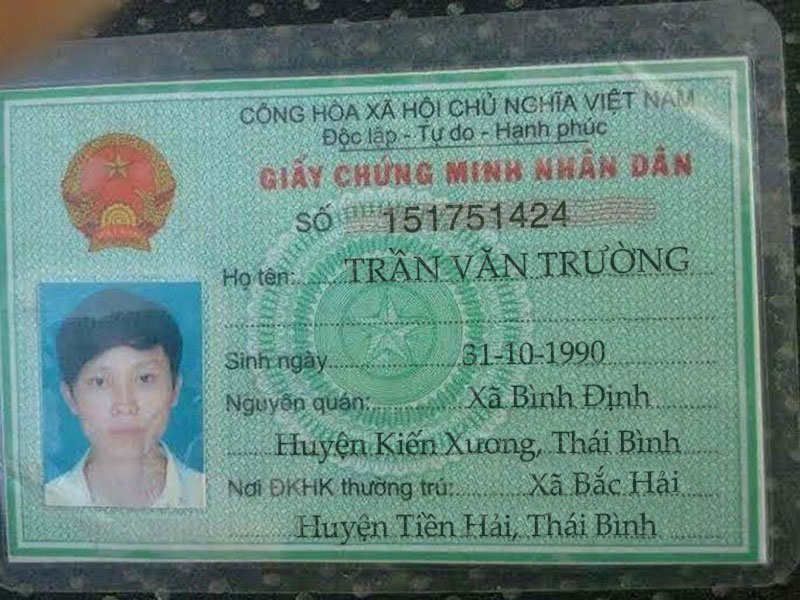

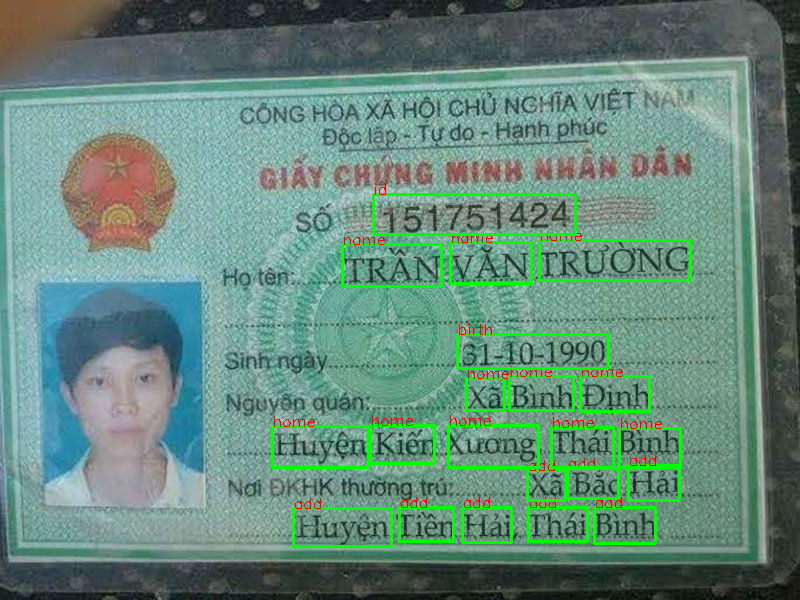

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import cv2
from utils import load_label_map
from utils.image_utils import non_max_suppression_fast

class Detector(object):
    def __init__(self, path_to_model, path_to_labels, nms_threshold=0.15, score_threshold=0.3):
        self.path_to_model = path_to_model
        self.path_to_labels = path_to_labels
        self.category_index = load_label_map.create_category_index_from_labelmap(path_to_labels, use_display_name=True)
        self.nms_threshold = nms_threshold
        self.score_threshold = score_threshold

        # load model
        self.interpreter = self.load_model()

        # Get input and output tensors.
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

        self.detection_scores = None
        self.detection_boxes = None
        self.detection_classes = None

    def load_model(self):
        # Load the TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_path=self.path_to_model)
        interpreter.allocate_tensors()

        return interpreter

    def predict(self, img):
        original = img
        height = self.input_details[0]['shape'][1]
        width = self.input_details[0]['shape'][2]
        img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
        img = np.expand_dims(img, axis=0)

        # Normalize input data
        input_mean = 127.5
        input_std = 127.5
        input_data = (np.float32(img) - input_mean) / input_std
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)

        self.interpreter.invoke()

        # Retrieve detection results
        self.detection_boxes = self.interpreter.get_tensor(self.output_details[0]['index'])[
            0]  # Bounding box coordinates of detected objects
        self.detection_classes = self.interpreter.get_tensor(self.output_details[1]['index'])[
            0]  # Class index of detected objects
        self.detection_scores = self.interpreter.get_tensor(self.output_details[2]['index'])[
            0]  # Confidence of detected objects

        mask = np.array(self.detection_scores) > self.score_threshold
        self.detection_boxes = np.array(self.detection_boxes)[mask]
        self.detection_classes = np.array(self.detection_classes)[mask]

        self.detection_classes += 1

        # Convert coordinate to original coordinate
        h, w, _ = original.shape
        self.detection_boxes[:, 0] = self.detection_boxes[:, 0] * h
        self.detection_boxes[:, 1] = self.detection_boxes[:, 1] * w
        self.detection_boxes[:, 2] = self.detection_boxes[:, 2] * h
        self.detection_boxes[:, 3] = self.detection_boxes[:, 3] * w

        # Apply non-max suppression
        self.detection_boxes, self.detection_classes = non_max_suppression_fast(boxes=self.detection_boxes,
                                                                                labels=self.detection_classes,
                                                                                overlapThresh=self.nms_threshold)
        return self.detection_boxes, np.array(self.detection_classes).astype("int"), self.category_index

    def draw(self, image):
        self.detection_boxes, self.detection_classes, self.category_index = self.predict(image)
        height, width, _ = image.shape

        for i in range(len(self.detection_classes)):
            label = str(self.category_index[self.detection_classes[i]]['name'])
            real_ymin = int(max(1, self.detection_boxes[i][0]))
            real_xmin = int(max(1, self.detection_boxes[i][1]))
            real_ymax = int(min(height, self.detection_boxes[i][2]))
            real_xmax = int(min(width, self.detection_boxes[i][3]))

            cv2.rectangle(image, (real_xmin, real_ymin), (real_xmax, real_ymax), (0, 255, 0), 2)
            cv2.putText(image, label, (real_xmin, real_ymin), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
                        fontScale=0.5)

        return image

detection_model = Detector(path_to_model='./config_text_detection/model.tflite',
                           path_to_labels='./config_text_detection/label_map.pbtxt',
                           nms_threshold=0.2, score_threshold=0.3)
img = cv2.imread('cmnd.jpg')
cv2_imshow(img)
result = detection_model.draw(img)
cv2_imshow(result)
